In [1]:
from pymongo import MongoClient
import re

from __future__ import print_function

# gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import LdaMulticore

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# sklearn
from sklearn.cluster import KMeans
from nltk.corpus import words
import nltk
import re

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

import html.parser

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
#Get my document sample

client = MongoClient()
db = client.sample_1m

db.sample_1m.find_one()

{'_id': ObjectId('5a9a2cc995de631f5450f245'),
 'author': 'InkognitoV',
 'author_flair_css_class': None,
 'author_flair_text': None,
 'body': 'I personally really enjoyed cs5430 system security. I took it in the Spring of 2015 and it was the most useful class I took in college. I think we had professor Clarkson and we worked in a team of 4 to build a password manager with a client and server. ',
 'can_gild': True,
 'controversiality': 0,
 'created_utc': 1515390775,
 'distinguished': None,
 'edited': False,
 'gilded': 0,
 'id': 'dscsqak',
 'is_submitter': False,
 'link_id': 't3_7ouol0',
 'parent_id': 't3_7ouol0',
 'permalink': '/r/Cornell/comments/7ouol0/good_cs_4000_level_classes/dscsqak/',
 'retrieved_on': 1517676184,
 'score': 3,
 'stickied': False,
 'subreddit': 'Cornell',
 'subreddit_id': 't5_2r0sd',
 'subreddit_type': 'public'}

In [4]:
cursor = db.sample_1m.find({ "subreddit": "gaming" ,
                              "body": { "$exists": True},
                              "body": { "$nin": ['[deleted]', '[removed]'] }}, 
                            { "body": 1 })

In [5]:
sample_entries = list(cursor)
sample = [x['body'] for x in sample_entries] # if (x['body'] != '[deleted]' and x['body'] != '[removed]')

In [6]:
len(sample)

5175

## Preprocessing

In [37]:
#remove links
X = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', string) for string in sample]

In [38]:
#remove new lines
X = [string.replace('\n', ' ') for string in X]

In [39]:
#convert html syntax to humanly readable characters
X = [html.unescape(string) for string in X]

In [40]:
lemmatizer = WordNetLemmatizer()

X = [" ".join([lemmatizer.lemmatize(word, 'v') for word in string.split(" ")]) for string in X]
X = [" ".join([lemmatizer.lemmatize(word, 'n') for word in string.split(" ")]) for string in X]
X = [" ".join([lemmatizer.lemmatize(word, 'a') for word in string.split(" ")]) for string in X]

In [41]:
import string
tokens = []

for doc in X:
    lowers = doc.lower()
    translator = str.maketrans('','',string.punctuation)    
    no_punctuation = lowers.translate(translator)
    tokens.append(no_punctuation)

## Modeling

In [42]:
# Vectorize the text using TFIDF
tfidf = TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z][a-zA-Z]+\\b", #words with >= 2 alpha chars 
                        min_df = 15,
                        max_df = .70,
                        ngram_range=(1, 3))

tfidf_vecs = tfidf.fit_transform(tokens)

In [43]:
n_comp = 600

In [44]:
from sklearn.decomposition import TruncatedSVD

tfidf_svd_v2 = TruncatedSVD(n_components=n_comp, n_iter=100, random_state=2)
review_reduced_v2 = tfidf_svd_v2.fit_transform(tfidf_vecs)  
print(tfidf_svd_v2.explained_variance_ratio_) 
print(tfidf_svd_v2.singular_values_)

[0.01249287 0.01259209 0.01143507 0.00970717 0.00963307 0.00934335
 0.00858632 0.00834303 0.00769426 0.00768984 0.00750513 0.00708999
 0.00683458 0.00663085 0.00639698 0.00616599 0.0059134  0.00571154
 0.00566348 0.00554416 0.00547197 0.00537569 0.00534357 0.00518655
 0.00509899 0.00502735 0.00500061 0.00482224 0.00477722 0.0046632
 0.00462489 0.00458468 0.00455583 0.00439909 0.00430263 0.0042676
 0.00422842 0.00415969 0.00409917 0.00402996 0.0039887  0.00392736
 0.0039228  0.0038307  0.00380574 0.00372304 0.00369743 0.00363711
 0.00358656 0.00353869 0.00354773 0.00350661 0.00348775 0.00346416
 0.00344319 0.00342431 0.00340493 0.003362   0.00332557 0.00330328
 0.00325261 0.00321012 0.00319523 0.00315324 0.00312724 0.00309263
 0.00308305 0.00307542 0.00306237 0.00300278 0.00296356 0.00295968
 0.00294178 0.00293072 0.00292074 0.0028978  0.00288781 0.00286051
 0.00283432 0.00280549 0.00279868 0.00277672 0.00274172 0.00273265
 0.00271288 0.00269665 0.00268582 0.00267978 0.00266269 0.002647

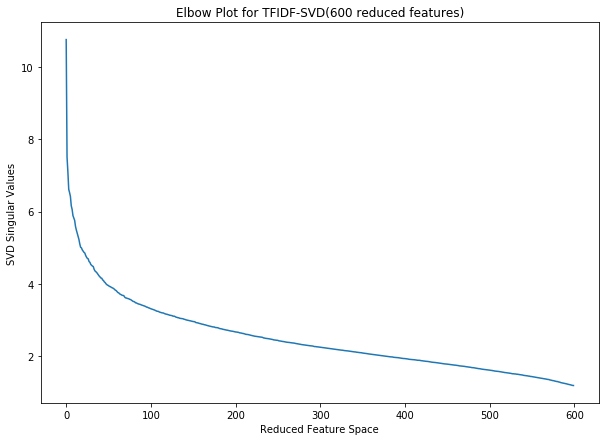

In [45]:
plt.figure(figsize=(10, 7))
plt.plot(range(0,n_comp), list(tfidf_svd_v2.singular_values_))
plt.xlabel('Reduced Feature Space')
plt.ylabel('SVD Singular Values')
plt.title('Elbow Plot for TFIDF-SVD(' + str(n_comp) + ' reduced features)');

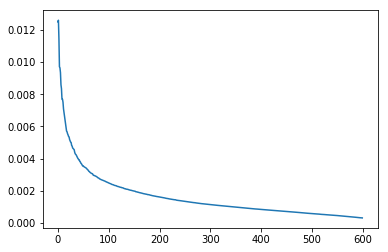

In [46]:
plt.plot(tfidf_svd_v2.explained_variance_ratio_);

In [47]:
print(tfidf_svd_v2.explained_variance_ratio_.sum())

0.9938146381284578


In [48]:
pd.DataFrame(tfidf_vecs.todense(), 
             columns=tfidf.get_feature_names()
             ).head()

,able,absolutely,access,account,action,actual,actually,add,affiliate,afford,...,year old,years,yes,youll,young,youre,youtube,youve,zelda,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants 
# terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(tfidf_vecs.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

2018-03-09 03:56:47,236 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-09 03:56:47,270 : INFO : built Dictionary(633 unique tokens: ['couple', 'day', 'play', 'hour', 'work']...) from 5175 documents (total 9683 corpus positions)


In [50]:
#declare my number of topics 
topics = 40

In [51]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
# Analagous to "fit" in sklearn, it primes an LSI space
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics = topics)

2018-03-09 03:56:47,278 : INFO : using serial LSI version on this node
2018-03-09 03:56:47,278 : INFO : updating model with new documents
2018-03-09 03:56:47,294 : INFO : preparing a new chunk of documents
2018-03-09 03:56:47,311 : INFO : using 100 extra samples and 2 power iterations
2018-03-09 03:56:47,311 : INFO : 1st phase: constructing (633, 140) action matrix
2018-03-09 03:56:47,348 : INFO : orthonormalizing (633, 140) action matrix
2018-03-09 03:56:47,387 : INFO : 2nd phase: running dense svd on (140, 5175) matrix
2018-03-09 03:56:47,670 : INFO : computing the final decomposition
2018-03-09 03:56:47,673 : INFO : keeping 40 factors (discarding 48.387% of energy spectrum)
2018-03-09 03:56:47,676 : INFO : processed documents up to #5175
2018-03-09 03:56:47,678 : INFO : topic #0(10.759): 0.536*"game" + 0.314*"just" + 0.284*"like" + 0.257*"play" + 0.166*"dont" + 0.163*"good" + 0.159*"think" + 0.151*"time" + 0.145*"make" + 0.120*"people"
2018-03-09 03:56:47,680 : INFO : topic #1(7.508

In [52]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]
#doc_vecs[0]

In [53]:
# Create an index transformer that calculates similarity based on 
# our space
index = similarities.MatrixSimilarity(doc_vecs, 
                                      num_features=topics)

# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[6]]), key=lambda item: -item[1])

2018-03-09 03:56:47,855 : INFO : creating matrix with 5175 documents and 40 features


In [54]:
X_clust = matutils.corpus2dense(lsi_corpus, num_terms=topics).transpose()
X_clust = normalize(X_clust)

In [55]:
k_max = 400

In [56]:
SSEs = []
Sil_coefs = []
for k in range(2,k_max):
    km = KMeans(n_clusters=k, random_state=54, n_jobs = 12)
    km.fit(X_clust)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(X_clust, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 
   # print('k = ', k)

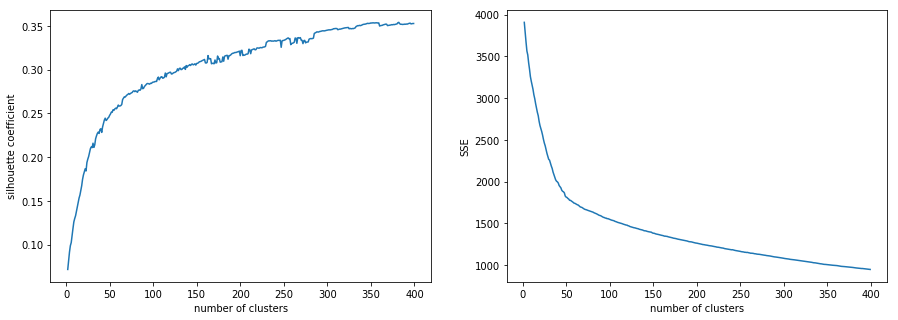

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,k_max)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');